In [17]:
from pandas import DataFrame, Index, read_csv
from tqdm import tqdm
from dslabs_functions import (
    select_low_variance_variables,
    study_variance_for_feature_selection,
    apply_feature_selection,
    select_redundant_variables,
    study_redundancy_for_feature_selection,
)


def select_low_variance_variables(
    data: DataFrame, max_threshold: float, target: str = "class"
) -> list:
    summary5: DataFrame = data.describe()
    vars2drop: Index[str] = summary5.columns[
        summary5.loc["std"] * summary5.loc["std"] < max_threshold
    ]
    vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop
    return list(vars2drop.values)


target = "JURISDICTION_CODE"
file_tag = "set_1"
train: DataFrame = read_csv("../dataset/train_dataset_1.csv")
train_sample = train.sample(frac=0.05)

100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


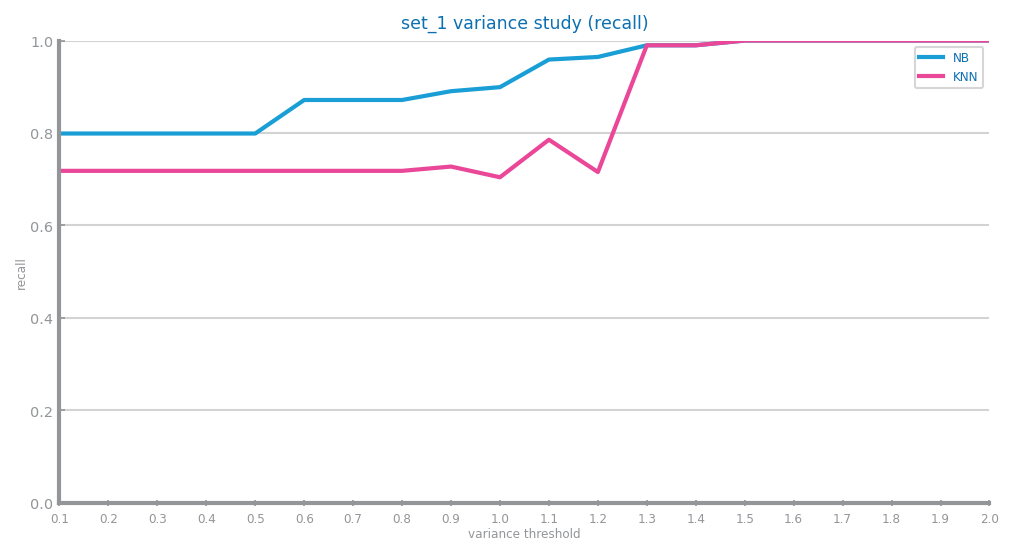

In [ ]:
from math import ceil
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import HEIGHT, evaluate_approach, plot_multiline_chart


def study_variance_for_feature_selection(
    train: DataFrame,
    test: DataFrame,
    target: str = "class",
    max_threshold: float = 1,
    lag: float = 0.05,
    metric: str = "accuracy",
    file_tag: str = "",
) -> dict:
    options: list[float] = [
        round(i * lag, 3) for i in range(1, ceil(max_threshold / lag + lag))
    ]
    results: dict[str, list] = {"NB": [], "KNN": []}
    summary5: DataFrame = train.describe()
    for thresh in tqdm(options):
        vars2drop: Index[str] = summary5.columns[
            summary5.loc["std"] * summary5.loc["std"] < thresh
        ]
        vars2drop = vars2drop.drop(target) if target in vars2drop else vars2drop

        train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
        test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
        eval: dict[str, list] | None = evaluate_approach(
            train_copy, test_copy, target=target, metric=metric
        )
        if eval is not None:
            results["NB"].append(eval[metric][0])
            results["KNN"].append(eval[metric][1])

    plot_multiline_chart(
        options,
        results,
        title=f"{file_tag} variance study ({metric})",
        xlabel="variance threshold",
        ylabel=metric,
        percentage=True,
    )
    savefig(f"images/{file_tag}_fs_low_var_{metric}_study.png")
    return results


eval_metric = "accuracy"
test: DataFrame = read_csv("../dataset/test_dataset_1.csv")
test_sample = test.sample(frac=0.05)

figure(figsize=(2 * HEIGHT, HEIGHT))
study_variance_for_feature_selection(
    train_sample,
    test_sample,
    target=target,
    max_threshold=2,
    lag=0.1,
    metric=eval_metric,
    file_tag=file_tag,
)
show()

In [ ]:
def apply_feature_selection(
    train: DataFrame,
    test: DataFrame,
    vars2drop: list,
    filename: str = "",
    tag: str = "",
) -> tuple[DataFrame, DataFrame]:
    train_copy: DataFrame = train.drop(vars2drop, axis=1, inplace=False)
    train_copy.to_csv(f"{filename}_train_{tag}.csv", index=False)
    test_copy: DataFrame = test.drop(vars2drop, axis=1, inplace=False)
    test_copy.to_csv(f"{filename}_test_{tag}.csv", index=False)
    return train_copy, test_copy


vars2drop: list[str] = select_low_variance_variables(
    train, max_threshold=0.7, target=target
)
train_cp, test_cp = apply_feature_selection(
    train, test, vars2drop, filename=f"../dataset/{file_tag}", tag="lowvar"
)
print(f"Original data: train={train.shape}, test={test.shape}")
print(f"After low variance FS: train_cp={train_cp.shape}, test_cp={test_cp.shape}")

In [ ]:
from pandas import Series


def select_redundant_variables(
    data: DataFrame, min_threshold: float = 0.90, target: str = "class"
) -> list:
    df: DataFrame = data.drop(target, axis=1, inplace=False)
    corr_matrix: DataFrame = abs(df.corr())
    variables: Index[str] = corr_matrix.columns
    vars2drop: list = []
    for v1 in variables:
        vars_corr: Series = (corr_matrix[v1]).loc[corr_matrix[v1] >= min_threshold]
        vars_corr.drop(v1, inplace=True)
        if len(vars_corr) > 1:
            lst_corr = list(vars_corr.index)
            for v2 in lst_corr:
                if v2 not in vars2drop:
                    vars2drop.append(v2)
    return vars2drop